# Import Libraries

In [119]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [120]:
data=pd.read_csv("C:\\Users\\naikn\\Downloads\\2024-01-18 6_33pm.csv")

In [121]:
data.columns

Index(['SKU', 'CONDITION', 'SIZE', 'GENDER', 'SOLD_AT', 'SOLD_PRICE', 'SOURCE',
       'SIZE_VALUE', 'BRAND', 'NAME', 'COLORWAY', 'COLOR', 'SILHOUETTE',
       'RETAILPRICE', 'RELEASEDATE', 'IS_COLLAB', 'COLLABORATOR'],
      dtype='object')

# DATA CLEANING

In [122]:
data=data.dropna()

In [6]:
print(data.isin([np.inf, -np.inf]).sum())

SKU             0
CONDITION       0
SIZE            0
GENDER          0
SOLD_AT         0
SOLD_PRICE      0
SOURCE          0
SIZE_VALUE      0
BRAND           0
NAME            0
COLORWAY        0
COLOR           0
SILHOUETTE      0
RETAILPRICE     0
RELEASEDATE     0
IS_COLLAB       0
COLLABORATOR    0
dtype: int64


In [123]:
data['IS_COLLAB']=data['IS_COLLAB'].astype(bool)
data['IS_COLLAB']=data['IS_COLLAB'].astype(str)
data['SOLD_AT']=pd.to_datetime(data['SOLD_AT'])
data['YEAR']=data['SOLD_AT'].dt.year
data['MONTH']=data['SOLD_AT'].dt.month
#Commenting it for testing the time series problem 
data['YEAR-MONTH']=data['SOLD_AT'].dt.strftime('%Y-%m')
data['NET_PROFIT']=data['SOLD_PRICE']-data['RETAILPRICE']

# Time Series data 
# Ensure the DataFrame has a DatetimeIndex with a frequency
#data.set_index('SOLD_AT', inplace=True)
#data.sort_index(inplace=True)  # Make sure it's sorted by the datetime index


# Exploratory Data Analysis (EDA)

# A. Inconsistent Size values for each size_value 

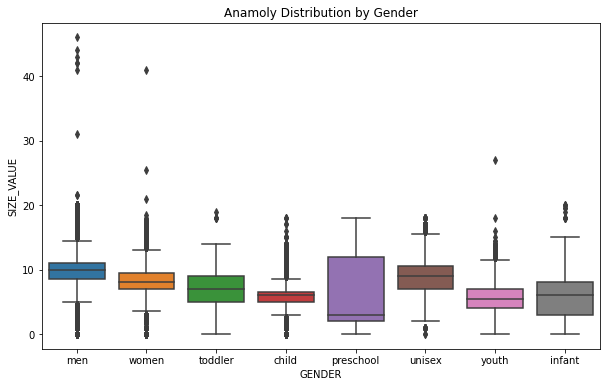

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(x="GENDER", y="SIZE_VALUE",data=data)
plt.title("Anamoly Distribution by Gender")
plt.show()

# B. Trend chart for Profit Margin Difference between SP and Actual Price

In [13]:
data_women=data[data['GENDER']=='women'].groupby(['YEAR-MONTH'])['NET_PROFIT'].sum().reset_index(name='SUM')
data_women['SUM']=data_women['SUM']/1000000
data_men=data[data['GENDER']=='men'].groupby(['YEAR-MONTH'])['NET_PROFIT'].sum().reset_index(name='SUM')
data_men['SUM']=data_men['SUM']/1000000


In [18]:
#Set a Standard Plotting Size
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

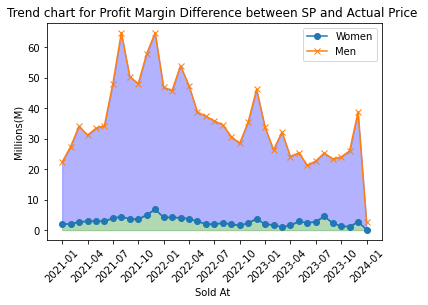

In [22]:
plt.plot(data_women['YEAR-MONTH'],data_women['SUM'],marker='o',label="Women")
plt.plot(data_men['YEAR-MONTH'],data_men['SUM'],marker='x',label="Men")
plt.fill_between(data_men['YEAR-MONTH'],data_women['SUM'],data_men['SUM'],alpha=0.3, color='blue')
plt.fill_between(data_men['YEAR-MONTH'],data_women['SUM'],alpha=0.3, color='green')

plt.title("Trend chart for Profit Margin Difference between SP and Actual Price ")
# Adding labels and title
plt.xlabel('Sold At ')
plt.ylabel('Millions(M)')
plt.legend()
# Set x-axis ticks at an interval of 3 months
x_ticks = data_men['YEAR-MONTH'][::3]
plt.xticks(x_ticks, rotation=45)

plt.show()

# C. Gender Wise Frequency Percentage of Data Available

In [23]:
data_gender=data['GENDER'].value_counts().reset_index(name='Count')
data_gender.columns=['GENDER', 'COUNT']
data_gender['COUNT']=round(data_gender['COUNT']/data_gender['COUNT'].sum()*100,2)

Text(0, 0.5, 'Percentage%')

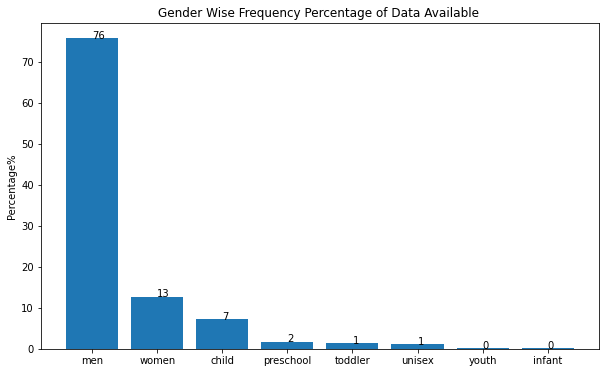

In [25]:
plt.figure(figsize=(10,6))
bar_plot=plt.bar(data_gender['GENDER'],data_gender['COUNT'])
for bar in bar_plot:
    bar_height=bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,bar_height,round(bar_height))
    #print(bar_height)
plt.title("Gender Wise Frequency Percentage of Data Available ")
plt.ylabel("Percentage%")


# D. Trend Chart to show net profit distribution for top 3 brands 

In [27]:
# Data Preparation for Trend for Men 
data_Year_Brand_Gender=data.groupby(['YEAR-MONTH','BRAND','GENDER'])['NET_PROFIT'].sum().reset_index(name='NET_PROFIT')
data_Year_Brand_Gender.sort_values(by=['NET_PROFIT','GENDER','YEAR-MONTH'], ascending=False)
data_Nike=data_Year_Brand_Gender[(data_Year_Brand_Gender['BRAND']=='Nike')&(data_Year_Brand_Gender['GENDER']=='men')]
data_Jordan=data_Year_Brand_Gender[(data_Year_Brand_Gender['BRAND']=='Jordan')&(data_Year_Brand_Gender['GENDER']=='men')]
data_adidas=data_Year_Brand_Gender[(data_Year_Brand_Gender['BRAND']=='adidas')&(data_Year_Brand_Gender['GENDER']=='men')]

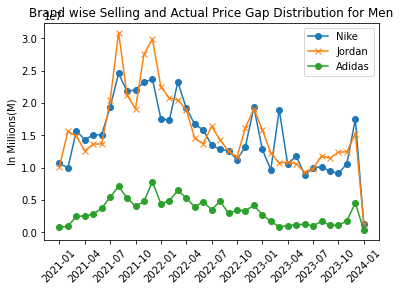

In [31]:
# Plotting the trend for men 
plt.plot(data_Nike['YEAR-MONTH'],data_Nike['NET_PROFIT'] ,marker='o', label="Nike")
plt.plot(data_Jordan['YEAR-MONTH'],data_Jordan['NET_PROFIT'] ,marker='x',label="Jordan")
plt.plot(data_adidas['YEAR-MONTH'],data_adidas['NET_PROFIT'] ,marker='o', label="Adidas")
plt.title("Brand wise Selling and Actual Price Gap Distribution for Men")
plt.ylabel("In Millions(M)")
plt.legend()

# Set x-axis ticks at an interval of 3 months
x_ticks = data_Nike['YEAR-MONTH'][::3]
plt.xticks(x_ticks, rotation=45)

plt.show()


# E. COLLABORATOR ANALYSIS 

In [32]:
#Calculate the proporation of data for every Collaborator 
data_collab=data['COLLABORATOR'].value_counts().reset_index()
data_collab['COLLABORATOR_RATIO']=data_collab['COLLABORATOR']/len(data_collab)
data_collab.columns=['Name','COLLABORATOR','COLLABORATOR_RATIO\(%)']
data_collab=data_collab.groupby(['Name'])['COLLABORATOR'].sum().reset_index(name='COLLABORATOR')
data_collab['COLLABORATOR_RATIO']=round(data_collab['COLLABORATOR']/data_collab['COLLABORATOR'].sum()*100,2)

In [33]:
data_collab.head(10000)
data_collab.sort_values(by="COLLABORATOR_RATIO", ascending =[False])

,Name,COLLABORATOR,COLLABORATOR_RATIO
0,None,20407819,85.70
35,kanye west,1725451,7.25
78,virgil abloh,185460,0.78
73,travis scott,163746,0.69
67,supreme,154225,0.65
...,...,...,...
54,rihanna,62,0.00
60,saweetie,56,0.00
59,satisfy,383,0.00
58,sankuanz,499,0.00


# Data Filtering for model preparation

In [124]:
brand_data = data[data['BRAND'] == 'Jordan']

In [125]:
brand_data['SOLD_AT']=pd.to_datetime(brand_data['SOLD_AT'])

C:\Users\naikn\AppData\Local\Temp\ipykernel_9168\714765983.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
brand_data['SOLD_AT'] = brand_data['SOLD_AT'].dt.floor('D')

C:\Users\naikn\AppData\Local\Temp\ipykernel_9168\1870031735.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
brand_data_day=brand_data.groupby(brand_data['SOLD_AT'].dt.to_period('D'))["SOLD_PRICE"].sum().reset_index()

C:\Users\naikn\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [128]:
brand_data_day.set_index('SOLD_AT',inplace=True)

<AxesSubplot:xlabel='SOLD_AT'>

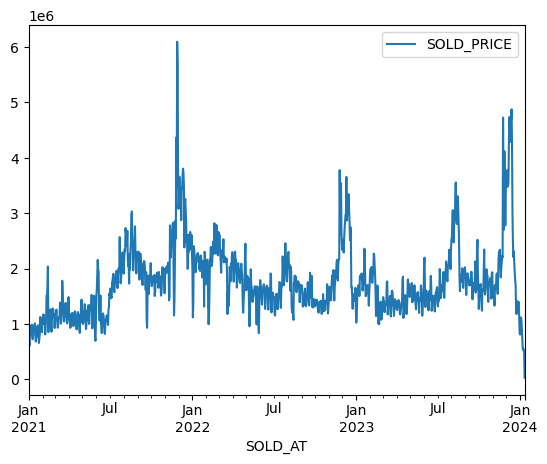

In [129]:
brand_data_day.plot()

# Preparing Training and Test Data 

In [130]:
brand_data_day_train=brand_data_day[:len(brand_data_day)-17]
brand_data_day_test=brand_data_day[len(brand_data_day)-17:]

In [131]:
len(brand_data_day_train)

1089

<AxesSubplot:xlabel='SOLD_AT'>

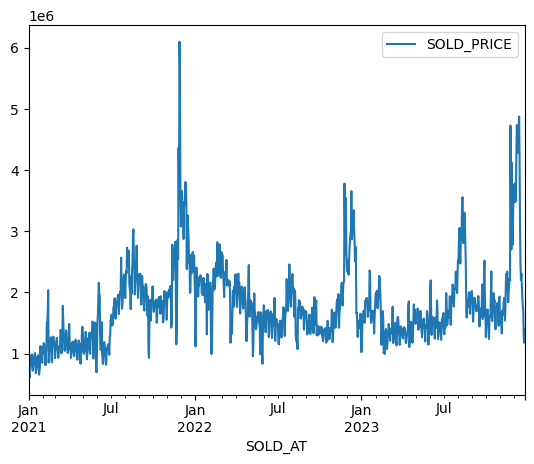

In [132]:
brand_data_day_train.plot()

<AxesSubplot:xlabel='SOLD_AT'>

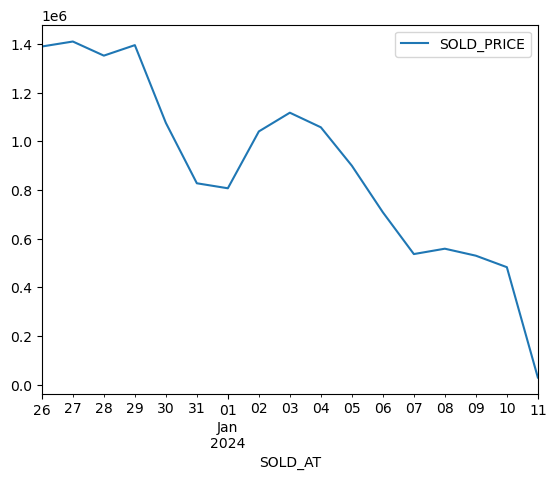

In [133]:
brand_data_day_test.plot()

# Test for the stationarity of a time series.

In [134]:
result=adfuller(brand_data_day_train)


In [135]:

# Printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# You might also want to print the null hypothesis rejection decision based on the p-value
alpha = 0.05
if result[1] <= alpha:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is non-stationary")


ADF Statistic: -5.14736815513933
p-value: 1.124917744269502e-05
Critical Values:
	1%: -3.4364992651202697
	5%: -2.8642551098431968
	10%: -2.5682156239065925
Reject the null hypothesis - Data is stationary


# Plotting ACF and PACF Plots for time series analysis 

p-value is extremely close to 0 . Therefore it is stationary 

C:\Users\naikn\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



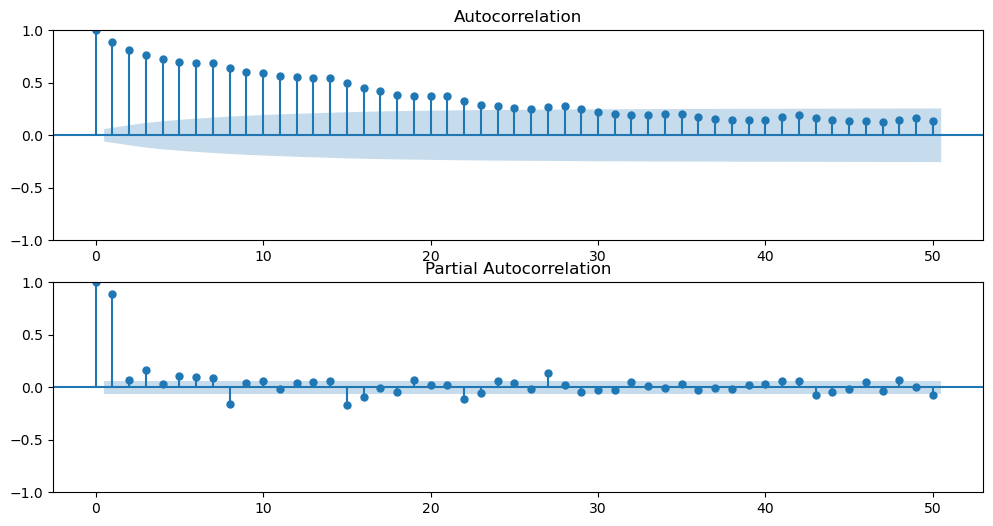

In [136]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax=plt.subplots(2, figsize=(12,6))
ax[0]=plot_acf(brand_data_day_train, ax=ax[0],lags=50)
ax[1]=plot_pacf(brand_data_day_train,ax=ax[1],lags=50)

# Decomposition of time series 

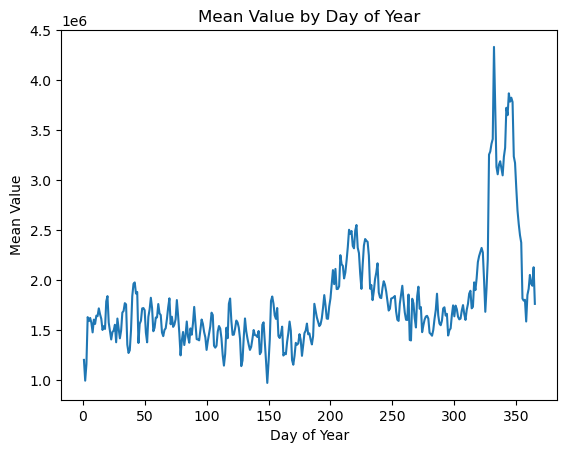

In [137]:
import seaborn as sns

# Assuming 'brand_data_day_train' is your DataFrame with a datetime index
# Aggregate data over days and plot
sns.lineplot(x=brand_data_day_train.index.dayofyear, y=brand_data_day_train['SOLD_PRICE'], ci=None)
plt.xlabel('Day of Year')
plt.ylabel('Mean Value')
plt.title('Mean Value by Day of Year')
plt.show()


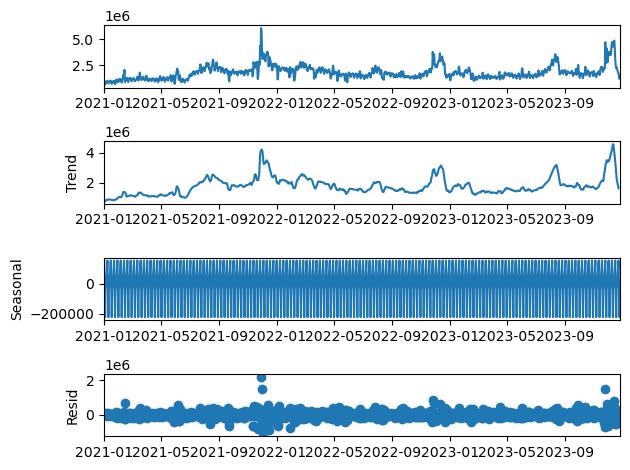

In [138]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Assuming brand_data_day_train is your DataFrame

# Convert the minimum and maximum values of the index to Timestamps
start_date = brand_data_day_train.index.min().to_timestamp()
end_date = brand_data_day_train.index.max().to_timestamp()

# Create a new DateTimeIndex with the desired frequency
brand_data_day_train.index = pd.date_range(start=start_date, end=end_date, freq='D')

# Alternatively, you can use the `asfreq()` method
brand_data_day_train = brand_data_day_train.asfreq('D')


# Perform seasonal decomposition
ts_decomp = sm.tsa.seasonal_decompose(brand_data_day_train, model='additive')

# Plot the decomposed components
ts_decomp.plot()
plt.show()


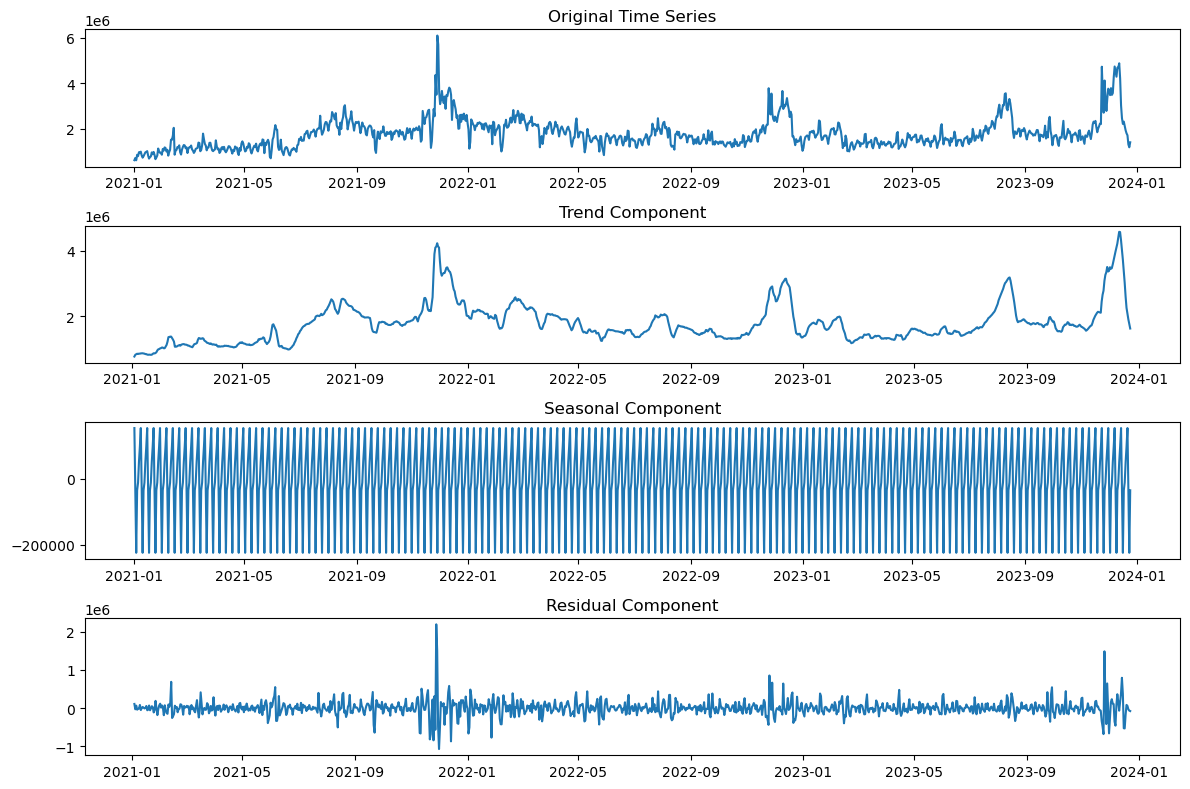

In [139]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'brand_data_day_train' is your DataFrame with a datetime index
# Perform seasonal decomposition
result = seasonal_decompose(brand_data_day_train, model='additive')

# Plot the decomposition components
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(brand_data_day_train)
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


# MODEL PREPARATION

In [140]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define the parameters for the ARIMA model
p = 25  # Order of autoregression
d = 0   # Order of differencing (based on the trend component)
q = 25  # Order of moving average
P = 0   # Seasonal autoregression order (no seasonality)
D = 1   # Seasonal differencing order (to eliminate the seasonality)
Q = 0   # Seasonal moving average order (no seasonality)

# Fit the ARIMA model
model = ARIMA(brand_data_day_train, order=(p, d, q), seasonal_order=(P, D, Q, 12))  # 1 for non-seasonal ARIMA
results = model.fit()

# Inspect model summary and diagnostics
print(results.summary())


C:\Users\naikn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\naikn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\naikn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                          SOLD_PRICE   No. Observations:                 1089
Model:             ARIMA(25, 0, 25)x(0, 1, [], 12)   Log Likelihood              -14996.783
Date:                             Mon, 25 Mar 2024   AIC                          30095.566
Time:                                     00:32:56   BIC                          30349.644
Sample:                                 01-01-2021   HQIC                         30191.785
                                      - 12-25-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0578      2.408      0.024      0.981      -4.661       4.777
ar.L2          0.0148      

In [141]:
# Step 3: Generate predictions
forecast_horizon = 20  # Number of future time periods to forecast
predictions = results.forecast(steps=forecast_horizon)

# Display predictions
print("Predictions:")
predictions=predictions.reset_index()
predictions['predicted_mean'] = predictions['predicted_mean'].apply(lambda x: int(float(x)))


Predictions:


In [142]:
predictions

,index,predicted_mean
0,2023-12-26,1285882
1,2023-12-27,1151915
2,2023-12-28,1239846
3,2023-12-29,1259544
4,2023-12-30,882243
5,2023-12-31,727463
6,2024-01-01,1030417
7,2024-01-02,1004325
8,2024-01-03,914463
9,2024-01-04,978628


In [143]:
brand_data_day_test=pd.DataFrame(brand_data_day_test)

In [144]:
brand_data_day_test=brand_data_day_test.reset_index()

In [145]:
brand_data_day_test.columns

Index(['SOLD_AT', 'SOLD_PRICE'], dtype='object')

In [147]:
predictions = predictions.rename(columns={'index': 'SOLD_AT'})

In [148]:
brand_data_day_test['SOLD_AT'] = brand_data_day_test['SOLD_AT'].dt.to_timestamp()

In [149]:
predictions.dtypes

SOLD_AT           datetime64[ns]
predicted_mean             int64
dtype: object

In [150]:
brand_data_day_test.dtypes

SOLD_AT       datetime64[ns]
SOLD_PRICE           float64
dtype: object

In [151]:
merged_df = pd.merge(predictions, brand_data_day_test, on='SOLD_AT', how='inner')

In [152]:
merged_df['difference']=merged_df['predicted_mean']-merged_df['SOLD_PRICE']

In [34]:
brand_data_day_train=brand_data_day_train.reset_index()

In [35]:
brand_data_day_train['index']=pd.to_datetime(brand_data_day_train['index'])

In [36]:
brand_data_day_train['index']

0      2021-01-01
1      2021-01-02
2      2021-01-03
3      2021-01-04
4      2021-01-05
          ...    
1084   2023-12-21
1085   2023-12-22
1086   2023-12-23
1087   2023-12-24
1088   2023-12-25
Name: index, Length: 1089, dtype: datetime64[ns]

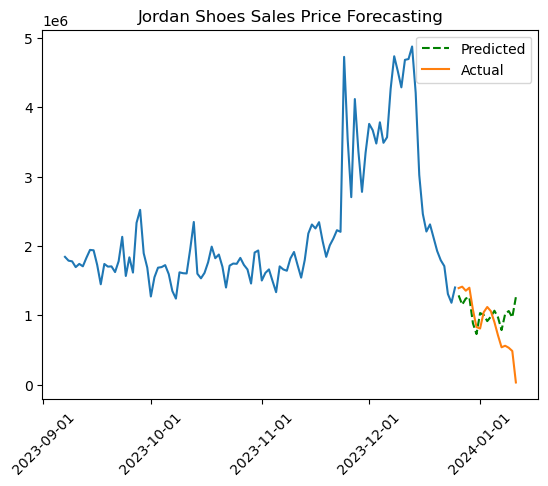

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Get the current date
current_date = datetime.now()

# Calculate the date one year ago
one_year_ago = current_date - timedelta(days=200)

# Filter the data for the last one year
last_year_data = brand_data_day_train[brand_data_day_train['index'] >= one_year_ago]
plt.plot(merged_df['SOLD_AT'], merged_df['predicted_mean'], label='Predicted', color='green', linestyle='--')
# Plot the last one year data
plt.plot(last_year_data['index'], last_year_data['SOLD_PRICE'])
plt.plot(merged_df['SOLD_AT'], merged_df['SOLD_PRICE'], label='Actual')
# Format x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show ticks at month level

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.title("Jordan Shoes Sales Price Forecasting")
plt.show()


In [39]:
brand_data_day_train.columns

Index(['index', 'SOLD_PRICE'], dtype='object')

# DASHBOARD DEVELOPMENT 

In [112]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.graph_objs as go
import webbrowser

# Sample DataFrames
df1 = pd.DataFrame({
    'Date': pd.date_range(start='2022-01-01', end='2022-12-31'),
    'Column1': [i for i in range(1, 366)],
    'Column2': [i**2 for i in range(1, 366)]
})

df2 = pd.DataFrame({
    'Date': pd.date_range(start='2022-01-01', end='2022-12-31'),
    'Column3': [i**3 for i in range(1, 366)]
})


trace2 = go.Scatter(
        x=last_year_data['index'],
        y=last_year_data['SOLD_PRICE'],
        mode='lines+markers',
        marker=dict(color='red'),
        name='SOLD_PRICE'
    )

# Initialize Dash app
app = dash.Dash(__name__)

# Define layout of the app
app.layout = html.Div(style={'display': 'flex', 'justifyContent': 'flex-start', 'alignItems': 'center', 'flexDirection': 'column'}, children=[
    html.H1("Simple Dashboard", style={'textAlign': 'center'}),
    html.Div(style={'textAlign': 'left', 'marginBottom': '20px', 'width': '30%'}, children=[
        html.Label("Select a column from DataFrame 1:"),
        dcc.Dropdown(
            id='dropdown-column1',
            options=[{'label': col, 'value': col} for col in merged_df.columns[1:]],
            value='Column1'
        )
    ]),
  
    html.Div(style={'textAlign': 'left', 'marginBottom': '20px', 'width': '30%'}, children=[
        html.Label("Select a column from DataFrame 2:"),
        dcc.Dropdown(
            id='dropdown-column3',
            options=[{'label': col, 'value': col} for col in merged_df.columns[1:]],
            value='Column3'
        )
    ]),
    dcc.Graph(id='line-plot', style={'width': '80%', 'height': '80vh'})
])

# Define callback to update the plot
@app.callback(
    Output('line-plot', 'figure'),
    [Input('dropdown-column1', 'value'),
     Input('dropdown-column3', 'value')]
)
def update_plot(selected_column1, selected_column3):
    trace1 = go.Scatter(
        x=merged_df['SOLD_AT'],
        y=merged_df[selected_column1],
        mode='lines+markers',
        marker=dict(color='blue'),
        name=selected_column1
    )

    trace3 = go.Scatter(
        x=merged_df['SOLD_AT'],
        y=merged_df[selected_column3],
        mode='lines+markers',
        marker=dict(color='green'),
        name=selected_column3
    )
    layout = go.Layout(
        title="Line Plot of Columns",
        xaxis=dict(title='Date'),
        yaxis=dict(title='Value')
    )
    return {'data': [trace1, trace2, trace3], 'layout': layout}

# Run the app
if __name__ == '__main__':
    app.run_server(debug=False, port=8050)
    webbrowser.open_new_tab('http://127.0.0.1:8050/')


[2024-03-25 00:15:02,276] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\naikn\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 3629, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Column1'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\naikn\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\naikn\anaconda3\lib\site-packages\flask\app.py", line 1952, 